In [1]:
import os
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from IPython.display import HTML, display, Video

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    TimeDistributed,
    Flatten,
    ConvLSTM2D,
    BatchNormalization,
    Dropout,
    Bidirectional,
    LSTM,
    Dense,
    Attention,
    Reshape,
    Add,
    Activation,
    SpatialDropout2D,
    LayerNormalization,
    MultiHeadAttention,
    GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import swish

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = 64
SEQ_LEN = 20
DATA_DIR = '/content/drive/MyDrive/HockeyFights'

In [4]:
def load_data(data_dir, seq_len=SEQ_LEN, img_size=IMG_SIZE):
    X, y = [], []
    for label in ['Violence', 'NonViolence']:
        folder = os.path.join(data_dir, label)
        for video in os.listdir(folder):
            frames = []
            cap = cv2.VideoCapture(os.path.join(folder, video))
            while len(frames) < seq_len and cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (img_size, img_size))
                frame = frame / 255.0
                frames.append(frame)
            cap.release()
            if len(frames) == seq_len:
                X.append(frames)
                y.append(1 if label == 'Violence' else 0)
    return np.array(X), np.array(y)

In [5]:
X, y = load_data(DATA_DIR)
X = X.reshape((-1, SEQ_LEN, IMG_SIZE, IMG_SIZE, 3))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def plot_training_curves(history, title='Model'):
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [7]:
def predict_video(model, video_path, seq_len=20, img_size=64):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < seq_len and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()

    if len(frames) != seq_len:
        print(f"Error: Only {len(frames)} frames extracted. {seq_len} required.")
        return

    input_data = np.array(frames).reshape((1, seq_len, img_size, img_size, 3))
    prediction = model.predict(input_data)[0][0]

    print("Prediction Confidence:", prediction)
    if prediction >= 0.5:
        print("Violence Detected")
    else:
        print("No Violence Detected")

In [8]:
def detect_violence_from_upload(model, seq_len=20, img_size=64):
    print("Please upload a video file ...")
    uploaded = files.upload()

    if not uploaded:
        print("No file was uploaded.")
        return

    # Get the first uploaded file
    for name, data in uploaded.items():
        video_path = f"/content/{name}"
        with open(video_path, 'wb') as f:
            f.write(data)
        break

    print(f"\n Video saved to: {video_path}")

    # Extract frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened() and len(frames) < seq_len:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (img_size, img_size))
        frame = frame.astype('float32') / 255.0
        frames.append(frame)
    cap.release()

    if len(frames) < seq_len:
        print(f"Only {len(frames)} frames extracted (need at least {seq_len}).")
        return

    input_data = np.array(frames).reshape((1, seq_len, img_size, img_size, 3))
    prediction = model.predict(input_data)[0][0]

    print(f"Prediction Confidence: {round(prediction, 4)}")
    print("Violence Detected" if prediction >= 0.5 else "No Violence Detected")

## **Proposed Model**

In [9]:
def residual_block(x, filters):
    shortcut = TimeDistributed(Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(SpatialDropout2D(0.3))(x)
    x = TimeDistributed(Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(0.001)))(x)
    x = Add()([x, shortcut])
    return Activation('relu')(x)

In [10]:
def VioNet(input_shape=(20, 64, 64, 3)):
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN + Residual Blocks
    x = residual_block(inputs, 32)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = residual_block(x, 64)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    # ConvLSTM with Dropout
    x = ConvLSTM2D(48, (3, 3), padding='same', return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Flatten + BiLSTM
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(48, return_sequences=True))(x)

    # MultiHeadAttention
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = GlobalAveragePooling1D()(x)  # replaces Flatten

    # Dense Classification Head
    x = Dense(96, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [11]:
model = VioNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=4,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 54s 188ms/step - accuracy: 0.6032 - loss: 0.9196 - val_accuracy: 0.8125 - val_loss: 0.7112 - learning_rate: 1.0000e-04
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.8877 - loss: 0.6249 - val_accuracy: 0.8062 - val_loss: 0.7621 - learning_rate: 1.0000e-04
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9197 - loss: 0.5599
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9196 - loss: 0.5600 - val_accuracy: 0.7875 - val_loss: 0.7694 - learning_rate: 1.0000e-04
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.9298 - loss: 0.5080 - val_accuracy: 0.5750 - val_loss: 1.2249 - learning_rate: 5.0000e-05
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.9263 - loss: 0.4998 - val_accuracy: 0.8813 - val_loss: 0.5857 - learning_rate: 5.0000e-05
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 16

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step
Accuracy: 0.935
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       104
           1       0.93      0.94      0.93        96

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



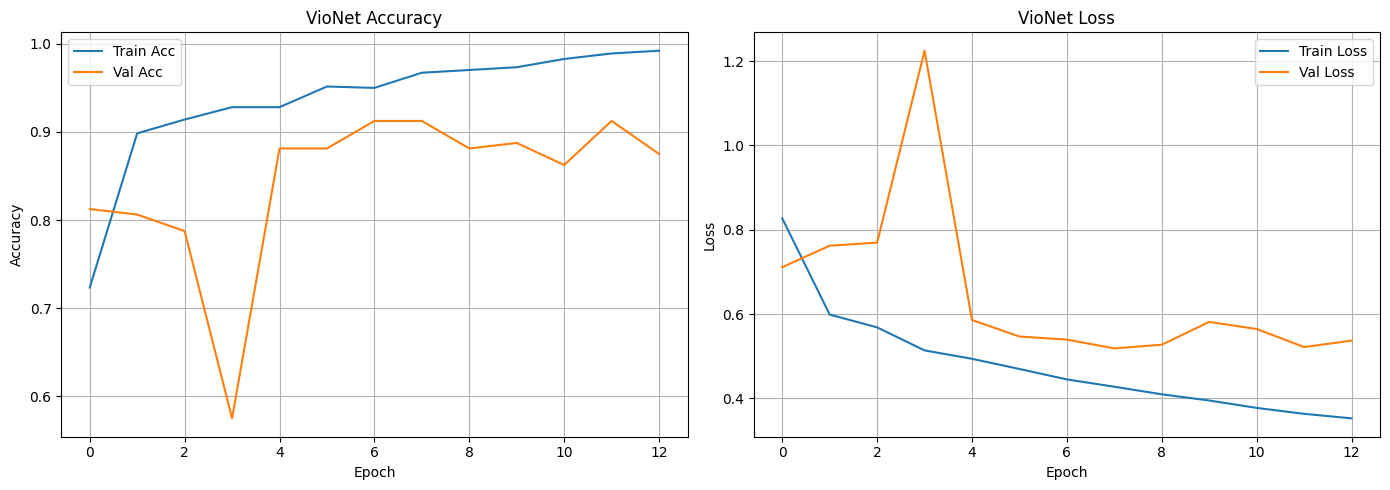

In [15]:
plot_training_curves(history, title='VioNet')

In [16]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


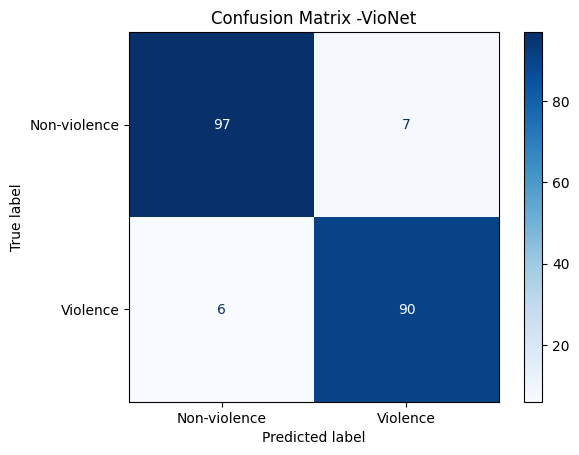

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-violence", "Violence"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix -VioNet")
plt.grid(False)
plt.show()

In [18]:
# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-violence", "Violence"]))

Classification Report:
              precision    recall  f1-score   support

Non-violence       0.94      0.93      0.94       104
    Violence       0.93      0.94      0.93        96

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



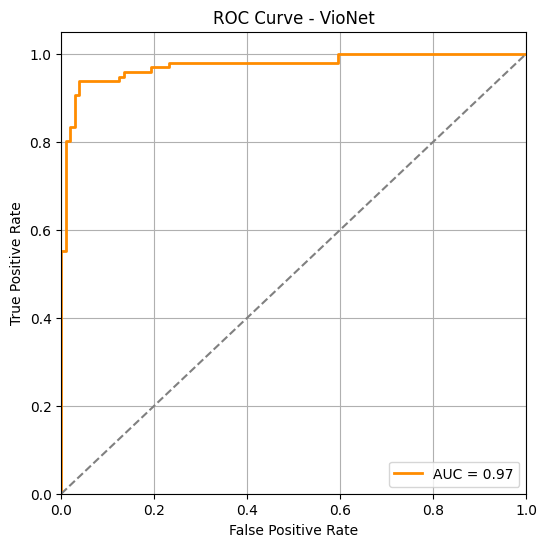

In [19]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - VioNet")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [20]:
predict_video(model, '/content/drive/MyDrive/HockeyFights/NonViolence/no107_xvid.avi')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Prediction Confidence: 0.02459043
No Violence Detected


In [21]:
predict_video(model, '/content/drive/MyDrive/HockeyFights/Violence/fi185_xvid.avi')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction Confidence: 0.9646237
Violence Detected


In [22]:
detect_violence_from_upload(model)

Please upload a video file ...


Saving no52_xvid.avi to no52_xvid.avi

 Video saved to: /content/no52_xvid.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction Confidence: 0.04580000042915344
No Violence Detected


In [23]:
detect_violence_from_upload(model)

Please upload a video file ...


Saving fi65_xvid.avi to fi65_xvid.avi

 Video saved to: /content/fi65_xvid.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction Confidence: 0.45579999685287476
No Violence Detected
